# Naive Bayes and Logistic Regression

Naive Bayes is popular in text classification tasks and sentiment analysis.

## Imports

In [1]:
import sys
import altair as alt
alt.renderers.enable("mimetype")
alt.data_transformers.enable('data_server')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## 1: Classifying happy moments 
<hr>

We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this project, we'll only use the examples where ground truth is available (~15,000 examples). 


In [2]:
df = pd.read_csv("../downloads/cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed afte...,My grandmother start to walk from the bed afte...,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and w...,I picked my daughter up from the airport and w...,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [3]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)
sample_df

,wid,reflection_period,original_hm,moment,modified,num_sentence,target,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed afte...,My grandmother start to walk from the bed afte...,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and w...,I picked my daughter up from the airport and w...,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding
...,...,...,...,...,...,...,...,...
128726,566,24h,yesterday chat with my brother in video call i...,yesterday chat with my brother in video call i...,False,1,affection,affection
128736,1580,24h,learning how to better hunt for hits on amazon...,learning how to better hunt for hits on amazon...,True,1,achievement,achievement
128746,248,24h,I woke up in the middle of the night and reali...,I woke up in the middle of the night and reali...,True,1,enjoy_the_moment,enjoy_the_moment


In [4]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

<br>  

### 1.1 Distribution of target values


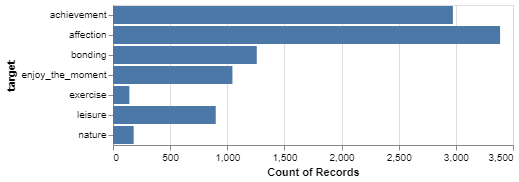

In [5]:
alt.Chart(pd.DataFrame(y_train)).mark_bar().encode(y="target", x="count()")

Achievement and Affection seem to be the target the most often and Exercise and Nature the least.

<br><br>

### 1.2 DummyClassifier 

We report mean cross-validation scores for `DummyClassifier`. The low mean cross-validation score can be attributed to the distribution of targets. Since `DummyClassifier` uses the most frequent target (affection in this case) as prediction, if we find its frequency we will have our CV score.
 

In [6]:
# from MDS notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [7]:
mean_std_cross_val_scores(DummyClassifier(), X_train, y_train, return_train_score=True)

fit_time       0.007 (+/- 0.003)
score_time     0.002 (+/- 0.002)
test_score     0.343 (+/- 0.000)
train_score    0.343 (+/- 0.000)
dtype: object

In [8]:
# We get the same score calculated by DummyClassifier this way
y_train.value_counts()["affection"] / y_train.shape[0]

0.34257105289774453

<br><br>

### 1.3 Different classifiers 

For each model in the starter code below, we carry out 5-fold cross-validation and report mean cross-validation scores, mean train scores, and mean fit and score times. 

> Note that in the given text, we use CountVectorizer with `binary=False` argument to extract binary features. The binary features (0/1) could be passed to `BernoulliNB`.
> `alpha` is by default set to 1 to apply smoothing on the final prediction of the model (to overcome the division over zero problem).
 

In [9]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "RBF SVM": SVC(),
    "BernoulliNB": BernoulliNB(alpha=1),
    "MultinomialNB": MultinomialNB(alpha=1),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class="ovr"),
}

In [10]:
results = pd.DataFrame()
for key, value in models.items():
    if key == "BernoulliNB":
        pipe = make_pipeline(CountVectorizer(stop_words='english', binary=True), value)
    else:
        pipe = make_pipeline(CountVectorizer(stop_words='english',), value)
    results[key] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True
    )

results

,Decision Tree,RBF SVM,BernoulliNB,MultinomialNB,Logistic Regression
fit_time,0.697 (+/- 0.026),6.440 (+/- 0.038),0.147 (+/- 0.009),0.141 (+/- 0.011),0.938 (+/- 0.045)
score_time,0.037 (+/- 0.009),0.960 (+/- 0.009),0.031 (+/- 0.000),0.034 (+/- 0.007),0.047 (+/- 0.016)
test_score,0.763 (+/- 0.010),0.801 (+/- 0.013),0.681 (+/- 0.004),0.759 (+/- 0.007),0.824 (+/- 0.005)
train_score,0.997 (+/- 0.000),0.930 (+/- 0.001),0.761 (+/- 0.002),0.861 (+/- 0.002),0.940 (+/- 0.001)


<br><br>

### 1.3 Discussion


1. Logistic regression has the highest CV score and the gap between CV and train score are small, showing that the model is performing well. After that are RBF SVM followed closely by Multinomial Naive Bayes both having lower CV scores, but small gaps between CV and train score. Among these Multinomial and Bernoulli Naive Bayes have the fastest fit time and score time. The very high trains score and low cross validation score for the decision tree implies overfitting.
2. Our target in this case has multiple classes. This is how each model in the list above might be tackling multi-class classification.
>Decision Tree: Same as binary classification, the end of each leaf could be a different class.  
>RBF SVM: Through the "one-vs-one" approach for multi-class classification a total of n * (n - 1) / 2 classifiers are constructed and each one trains data from two classes.   
>Naive Bayes: We can use the similar concept used for binary classification, but this time condition on multiple classes.  
>Logistic Regression: Multi-class classification is done using "one-vs-rest" or "one-vs-one" methods.

<br><br>

### 1.4 Hyperparameter optimization 
We will:
1. Define a pipeline with `CountVectorizer` and `LogisitcRegression` with `max_iter=2000` and `multi_class='ovr'`.
2. Using `RandomizedSearchCV`, jointly optimize `C` and `max_features` of logistic regression. 

In [11]:
from scipy.stats import uniform, loguniform

hyper_pipe = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(
        max_iter=2000,
        multi_class="ovr",  # one-vs-rest
    ),
)

param_distributions = {
    "countvectorizer__max_features": np.arange(5000, 10000, 100),
    "logisticregression__C": loguniform(1e-1, 1e2),
}

random_search = RandomizedSearchCV(
    hyper_pipe,
    param_distributions,
    n_iter=20,
    random_state=2021,
    return_train_score=True,
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(stop_words='english')),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=2000,
                                                                 multi_class='ovr'))]),
                   n_iter=20,
                   param_distributions={'countvectorizer__max_features': array([5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000,
       6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100,
       7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200,
       8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300,
       9400, 9500, 9600, 9700, 9800, 9900]),
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000281BACF58E0>},
                   random_state

In [12]:
random_search.best_score_

0.826538918492901

In [13]:
random_search.best_params_

{'countvectorizer__max_features': 7900,
 'logisticregression__C': 2.2721433695433677}

In [14]:
pd.DataFrame(random_search.cv_results_)[
    ["param_countvectorizer__max_features",
     "param_logisticregression__C",
     "mean_test_score",
     "mean_train_score",
     "rank_test_score"]
].sort_values("rank_test_score")

,param_countvectorizer__max_features,param_logisticregression__C,mean_test_score,mean_train_score,rank_test_score
11,7900,2.272143,0.826539,0.966749,1
19,9200,3.824791,0.825325,0.976434,2
15,7500,1.005352,0.823909,0.940629,3
17,6900,0.85794,0.822696,0.932968,4
9,9800,0.71106,0.821178,0.925331,5
18,7600,8.520291,0.820976,0.984601,6
12,9900,9.589561,0.820470,0.985309,7
6,8300,10.737467,0.819863,0.985966,8
1,9500,11.599434,0.819155,0.986346,9
16,8600,15.728057,0.817840,0.988192,10


We are getting similar average cross validation score compared to the default values.
The best model has slightly higher score compared to the next couple of scores."

<br><br><br><br>

## 2: Model interpretation 
<hr>

One of the primary advantage of linear models is their ability to interpret models in terms of important features by exploring the weights learned by the logistic regression classifier. 

### 2.1 Most informative words

We will use the best estimator from 3.7 to get
    - first 5 words that are positively associated and first 5 words which are negatively associated with the class "affection". 
    - first 5 words that are positively associated and first 5 words which are negatively associated with the class "exercise". 


> This information is exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. For multiclass classification, for each class the models learns coefficients per feature for that class. 

> The vocabulary (mapping from feature indices to actual words) is obtained by calling `get_feature_names_out()` on the `CountVectorizer` object. 


In [15]:
vocabs = random_search.best_estimator_["countvectorizer"].get_feature_names_out()
coeffs = random_search.best_estimator_["logisticregression"].coef_
targets = random_search.classes_
random_search_df = pd.DataFrame(coeffs, columns=vocabs).set_index(targets).T

pos_affection = (
    random_search_df.sort_values("affection", ascending=False).head().index.tolist()
)
neg_affection = random_search_df.sort_values("affection").head().index.tolist()

pos_exercise = (
    random_search_df.sort_values("exercise", ascending=False).head().index.tolist()
)
neg_exercise = random_search_df.sort_values("exercise").head().index.tolist()

print("Positively associated with 'affection':")
print("   ", ", ".join(pos_affection))
print("Negatively associated with 'affection':")
print("   ", ", ".join(neg_affection))

print("Positively associated with 'exercise':")
print("   ", ", ".join(pos_exercise))
print("Negatively associated with 'exercise':")
print("   ", ", ".join(neg_exercise))

Positively associated with 'affection':
    husband, wife, brother, son, daughter
Negatively associated with 'affection':
    friend, unforgettable, exam, friends, police
Positively associated with 'exercise':
    gym, workout, exercise, yoga, exercised
Negatively associated with 'exercise':
    dog, daughter, just, got, movie


<br><br>

### 2.2 Interpretation


- The positively associated words for affection and exercise make sense. However, it is hard to justify the negative words. It is very helpful to see what features our model is using to predict. For example, we have both `friend` and `friends` in our negatively associated affection list. Knowing this we would be able to do some further data transformation to minimize this nuisance and improve performance. The other thing that we could do by looking at these features is whether the features with highest weights really make sense.  
- It would be very hard to get the most informative features in other classifier. We could say that the top most point of a decision tree (root) is the most important feature, but that is not very informative in most of the cases. For SVM the most important features are multiple observations (arrays) which do not give any intuitive information. For Naive Bayes models, it would be very hard to find the features that contribute the most to the model especially if we have a multiclass target.

<br><br><br><br>

## 3: Test score and final evaluation
<hr>

Let's examine the performance of our best model on the test set. 

### 3.1 Evaluation on test data


In [16]:
best_maxfeature = list(random_search.best_params_.values())[0]
best_C = list(random_search.best_params_.values())[1]

In [17]:
optimized_pipe = make_pipeline(
    CountVectorizer(
        stop_words="english", 
        max_features=best_maxfeature
    ),
    LogisticRegression(
        C=best_C,
        max_iter=2000,
        multi_class="ovr",
    ),
)

optimized_pipe.fit(X_train, y_train)
optimized_pipe.score(X_test, y_test)

0.8187824445493157

The test score is very close to the cross validation score. Considering the large amount of data that has been used to train the model, we are confident that this model will be able to perform well for the population that the information was collected from.

<br><br>

### 3.2 Evaluation using probability scores

Using this model, we will try to find the moments in the test set: 

1. where the model is most confident that the moment belongs to class "achievement" (i.e., an example with highest predicted probability for class "achievement")
2. where the model is most confident that the moment belongs to class "nature" (i.e., an example with the highest predicted probability of being "nature")

In each case, print out the moment and the associated probability score. 

In [18]:
prob_df = pd.DataFrame(random_search.predict_proba(X_test), columns=targets)

max_achiev = prob_df["achievement"].idxmax()
max_achiev_prob = prob_df["achievement"].max()

print("Most confident for class 'achievement':")
print("Prob score:", max_achiev_prob)
X_test.iloc[max_achiev]

Most confident for class 'achievement':
Prob score: 0.9998551907675534


'An event that made me happy in the past 24 hours was when I was able to get a medical bill written off completely. The hospital had not followed proper procedures to get insurance approval for the treatment, which was a violation of their contract with the insurance company. Because of this the insurance company denied the claim and stated that I did not have to pay the bill. After spending 2.5 hours on the phone with the hospital and insurance company today it was concluded that the insurance company was correct and I did not have to pay the money.'

In [19]:
max_nature = prob_df["nature"].idxmax()
max_nature_prob = prob_df["nature"].max()
print("Most confident for class 'nature':")
print("Prob score:", max_nature_prob)
X_test.iloc[max_nature]

Most confident for class 'nature':
Prob score: 0.9475748027062482


'lucky to live in the country in New York on acres of land. A highlight of my trip was taking Ferg out for a hike in the woods with my cousin. I watched him sniff every possible thing in sight, while continuing to check in and make sure we were still with him.'

<br><br>

### 3.3 Fake moments 

We can test the best model on some fake moments. 

In [20]:
test_moments = [
    "On the weekend, I spent some quality time with my best friend.",
    "I love my kids!",
    "I went for a hike in the forest.",
    "I did yoga this morning.",
    "I am still breathing and I am alive!",
    "I am going to sleep",
]

In [21]:
optimized_pipe.predict(test_moments)

array(['bonding', 'affection', 'leisure', 'exercise', 'achievement',
       'leisure'], dtype=object)

The predictions look very promising, and except for one, are very accurate.

<br><br>

<br><br><br><br>

## 4: Summary and wrap up
<hr>

### 4.1: Qualitative comparison of classifiers 

So far I have been trying multiple models in this Kaggle repo and thought I will create a table with strengths and weaknesses:

<br>

Classifier |      Strengths | Weaknesses | Key hyperparameters |
:-----------|      :------------|:------------|:---------------------|
decision tree | Interpretable; Fast; $\mathcal{O}(\log n)$ prediction cost | Unstable with respect to data; prone to overfitting: sensitive to `max_depth` hyperparameter. | `max_depth` |
$k$-NN | Minimal training; few moving parts. Runs somewhere between $\mathcal{O}(d \log n)$ and $\mathcal{O}(dn)$, can learn complex decision boundaries | Sensitive to feature scaling, choice of $k$; curse of dimensionality; doesn't work well with sparse data | `k` (`n_neighbors` in `sklearn`) |
SVM | Powerful; prediction cost $\propto$ number of support vectors; works well with sparse data; able to learn complex functions  | Slow; doesn't scale well, sensitive to feature scaling and careful tuning of the hyperparameters `C` and `gamma`; Training is $\mathcal{O}(dn^2)$ | `C`, `gamma` |
naive Bayes | Fast; scales well; works well with sparse data; natural probabilistic interpretation. | Conditional independence often unrealistic; generalization performance is usually not that great | `alpha` |
logistic regression | Outputs have a nice probabilistic interpretation; Scales well; training time complexity is $\mathcal{O}(dn)$; works well with sparse data; the learned coefficient provide a nice interpretation for feature importances | doesn't work well when the decision boundaries are non-linear | `C` |